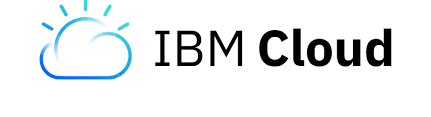

# CASE STUDY - Unsupervised Learning


In [1]:
import os
import joblib
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import BayesianGaussianMixture
from sklearn.svm import SVC
import imblearn.pipeline as pl
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, SVMSMOTE
    
    
plt.style.use('seaborn')
%matplotlib inline

DATA_DIR = os.path.join("..","data")

## Synopsis

  > We are now going to predict customer retention.  There are many models and many transforms to consider.  Use your
    knowledge of pipelines and functions to ensure that your code makes it easy to compare and iterate over.  
    
  > Marketing has asked you to make a report on customer retention.  They would like you to come up with information     that can be used to improve current marketing strategy efforts.  The current plan is for marketing at AAVAiL to
    collect more features on subscribers the and they would like to use your report as a proof-of-concept in order to     get buyin for this effort.
  
## Outline

1. Create a churn prediction baseline model
2. Use clustering as part of your prediction pipeline
3. Run and experiment to see if re-sampling techniques improve your model

## Data

Here we load the data as we have already done.

`aavail-target.csv`

In [2]:
df = pd.read_csv(os.path.join(DATA_DIR, r"aavail-target.csv"))

## pull out the target and remove uneeded columns
_y = df.pop('is_subscriber')
y = np.zeros(_y.size)
y[_y==0] = 1 
df.drop(columns=['customer_id', 'customer_name'], inplace=True)
df.head()

,country,age,subscriber_type,num_streams
0,united_states,21,aavail_premium,23
1,singapore,30,aavail_unlimited,12
2,united_states,21,aavail_premium,22
3,united_states,20,aavail_basic,19
4,singapore,21,aavail_premium,23


### QUESTION 1

Using the train_test_split() function, create a stratified train test split of the data

In [3]:
## YOUR CODE HERE


### QUESTION 2

Create a baseline model.  We are going to test whether clustering followed by a model improves the results.  Then, we will test whether re-sampling techniques provide improvements.  Use a pipeline or another method, but create a baseline model given the data. Here is the ColumnTransformer we have used before:

In [4]:
## preprocessing pipeline
numeric_features = ['age', 'num_streams']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = ['country', 'subscriber_type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encod', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [5]:
# YOUR CODE HERE (Replace the #<> symbols with your code)

# Create an instance of a binary classifier. 
#(You are free to choose the type of classifier that you think will best fit to the data)
clf = #<>

# Create a Pipeline that binds the preprocessing transformer and the classifier estimator.
# To improve the performace of the model you can add a gridsearch on the pipeline to optimize the classifier (optional)
pipe = #<>

# Fit the pipeline to the training data.
#<>

# predict the dependent variable of the test set.
y_pred = #<>

# Print the f1_score of the prediction.
print("f1_score", round(f1_score(y_test, y_pred, average='binary'), 3))

pre-->rf
f1_score 0.626


### QUESTION 3

The next part is to create a version of the classifier that uses identified clusters.  Here is a class to get you started.  It is a transformer like those that we have been working with.  There is an example of how to use it just below.  In this example 4 clusters were specified and their one-hot encoded versions were appended to the feature matrix.  Now using pipelines and/or functions compare the performance using cluster profiling as part of your matrix to the baseline.  You may compare multiple models and multiple clustering algorithms here.

In [6]:
class KmeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=4):
        self.n_clusters = n_clusters
        self.km = KMeans(n_clusters=self.n_clusters, n_init=20)
        
    def transform(self, X, *_):
        labels = self.km.predict(X)
        return np.hstack((X, labels.reshape(-1, 1)))

    def fit(self, X, y=None, *_):
        self.km.fit(X)
        labels = self.km.predict(X)
        self.silhouette_score = round(silhouette_score(X, labels, metric='mahalanobis'), 3)
        return self

class GmmTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=4):
        self.n_clusters = n_clusters
        self.gmm = BayesianGaussianMixture(n_components=self.n_clusters, covariance_type='full',
                                           max_iter=500, n_init=10, warm_start=True)        
    def transform(self, X,*_):
        probs = self.gmm.predict_proba(X) + np.finfo(float).eps
        return np.hstack((X, probs))
        
    def fit(self, X, y=None, *_):
        self.gmm.fit(X)
        labels = self.gmm.predict(X)
        self.silhouette_score = round(silhouette_score(X, labels, metric='mahalanobis'), 3)
        return self
    

    
## example for kmeans
preprocessor.fit(X_train)
X_train_pre = preprocessor.transform(X_train)    
kt = KmeansTransformer(4)
kt.fit(X_train_pre)
X_train_kmeans = kt.transform(X_train_pre)
print(X_train_pre.shape)
print(X_train_kmeans.shape)   
    
## example for GMM  
preprocessor.fit(X_train)
X_train_pre = preprocessor.transform(X_train)    
gt = GmmTransformer(4)
gt.fit(X_train_pre)
X_train_gmm = gt.transform(X_train_pre)
print(X_train_pre.shape)  
print(X_train_gmm.shape)

(750, 4)
(750, 8)
(750, 4)
(750, 5)


In [10]:
## YOUR CODE HERE (Replace the #<> symbols by your code)

def run_clustering_pipeline(umodel):
    """
    This function evaluates different Pipelines comprised of the preprocessing transfomer,
    a clustering transformer and a classifier estimator.
    INPUT : The name of the clustering transformer : 'gmm' or 'kmeans'
    OUTPUT : The list of f1_scores of the pipeline on the test set for the different number of clusters
    """
    
    
    fscores= [] # this list will store the f1_score of the different models that we will train
    for n_clusters in np.arange(3, 8):

        # Create an instance of a binary classifier (The same as the one you trained in the previous question)
        clf = #<>
        
        if umodel == 'gmm':
            # Create an instance of the Gmm transformer with n_clusters clusters
            cluster = #<>  
        elif umodel == 'kmeans':
            # Create an instance of the Kmean transformer with n_clusters clusters
            cluster = #<>
        else:
            raise Exception("invalid unsupervised learning model")
        
        # Create a Pipeline that binds the preprocessing transformer, the clustering transformer and the classifier estimator
        pipe = #<>
        
        # Fit the pipeline on training set
        #<>
        
        # Predict the test set
        y_pred = #<>
        
        # Compute the f1 score and add this score to the fscores list.
        score = round(f1_score(y_test, y_pred, average='binary'), 3)
        fscores.append(score)
        
    return fscores

## run the different iteration of the model
cp_results = {}
cp_results['kmeans'] = run_clustering_pipeline('kmeans')
cp_results['gmm'] = run_clustering_pipeline('gmm')

## display table of results
df_cp = pd.DataFrame(cp_results)
df_cp["n_clusters"] = [str(i) for i in np.arange(3,8)]
df_cp.set_index("n_clusters", inplace=True)
df_cp.head(n=10)

,kmeans,gmm
n_clusters,,
3,0.594,0.606
4,0.578,0.606
5,0.602,0.597
6,0.589,0.602
7,0.587,0.605


## QUESTION 4

Run an experiment to see if you can you improve on your workflow with the addition of re-sampling techniques? For instance, you can copy the structure of the function created in the previous question and add a re-sampling transformer to the pipeline.

In [8]:
## YOUR CODE HERE (Replace the #<> symbols by your code)

def run_clustering_pipeline(umodel):
    """
    This function evaluates different Pipelines constituated of the preprocessing transfomer,
    a clustering transformer, a re-sampling transformer and a classifier estimator.
    INPUT : The name of the clustering transformer : 'gmm' or 'kmeans'
    OUTPUT : The list of f1_scores of the pipeline on the test set for the different number of clusters.
    """
    
    #<>
        
    return(fscores)

## run the different iteration of the model
cp_results = {}
cp_results['kmeans'] = run_clustering_pipeline('kmeans')
cp_results['gmm'] = run_clustering_pipeline('gmm')


## display table of results
df_cp = pd.DataFrame(cp_results)
df_cp["n_clusters"] = [str(i) for i in np.arange(3,8)]
df_cp.set_index("n_clusters",inplace=True)
df_cp.head(n=10)

,kmeans,gmm
n_clusters,,
3,0.644,0.619
4,0.615,0.632
5,0.636,0.641
6,0.649,0.618
7,0.636,0.627
